<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Predict_Bitcoin_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict Bitcoin Price
## In this project, Bitcoind price is predicted using different methods including tensorflow deep learning models

In [3]:
import tensorflow as tf
from tensorflow.keras.metrics import (MeanAbsoluteError, 
                                      MeanSquaredError, 
                                      RootMeanSquaredError, 
                                      MeanAbsolutePercentageError)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-09 05:43:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-09 05:43:22 (96.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Get Data:

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-09-09 05:43:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2022-09-09 05:43:23 (50.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [7]:
bit_df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
            parse_dates = ['Date'],
            index_col = ['Date'])
bit_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [8]:
bitcoin_price = pd.DataFrame(bit_df['24h Open (USD)'])
bitcoin_price.head()

,24h Open (USD)
Date,
2013-10-01,124.30466
2013-10-02,123.65499
2013-10-03,125.45500
2013-10-04,108.58483
2013-10-05,118.67466


In [9]:
bitcoin_price.rename({'24h Open (USD)':'price'}, axis = 1 , inplace =True)
bitcoin_price.head()

,price
Date,
2013-10-01,124.30466
2013-10-02,123.65499
2013-10-03,125.45500
2013-10-04,108.58483
2013-10-05,118.67466


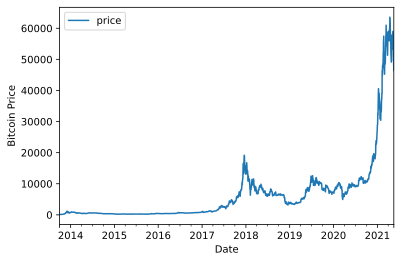

In [10]:
bitcoin_price.plot()
plt.ylabel('Bitcoin Price');

# Train Test Split:

In [11]:
price = bitcoin_price['price'].to_numpy()
price

array([  124.30466   ,   123.65499   ,   125.455     , ...,
       49926.03506746, 46805.53785192, 46439.3365698 ])

In [12]:
splitNum = int(0.85 * len(bitcoin_price))
bitcoin_price.index[:splitNum]

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
               '2013-10-05', '2013-10-06', '2013-10-07', '2013-10-08',
               '2013-10-09', '2013-10-10',
               ...
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25'],
              dtype='datetime64[ns]', name='Date', length=2368, freq=None)

In [13]:
splitNum = int(0.85 * len(bitcoin_price))
X_train, y_train = bitcoin_price.index[:splitNum] , bitcoin_price['price'].to_numpy()[:splitNum]
X_test, y_test = bitcoin_price.index[splitNum:] , bitcoin_price['price'].to_numpy()[splitNum:]

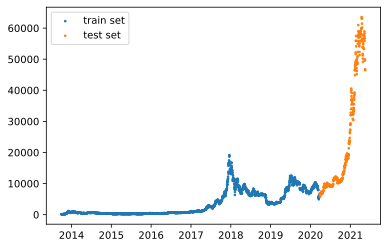

In [14]:
plt.scatter(X_train,y_train, s=3, label='train set')
plt.scatter(X_test,y_test, s=3, label='test set')
plt.legend();

# Experiments with different models:
## Naive Model: Simply, the forecast for the next day is the today`s value.

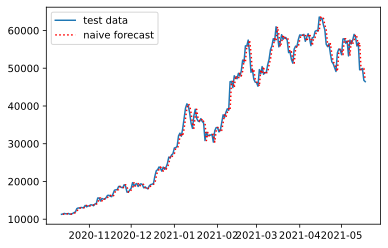

In [15]:
#start from 200 datapoint
plt.plot(X_test[200:], y_test[200:], label='test data')
plt.plot(X_test[201:], y_test[200:-1],'r:',label='naive forecast')
plt.legend();

### Evaluation:
MAE: Mean Absolute Error

MSE: Mean Squared Error

RMSE: Root Mean Squared Error

MAPE: Mean Absolute Percentage Error 

MASE: Mean Absolute Scaled Error

In [16]:
def errors(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  errors={'MAE': MeanAbsoluteError()(y_true, y_pred).numpy(),
          'MSE': MeanSquaredError()(y_true, y_pred).numpy(),
          'RMSE': RootMeanSquaredError()(y_true, y_pred).numpy(),
          'MAPE': MeanAbsolutePercentageError()(y_true, y_pred).numpy(),
          'MASE': (mae/mae_naive).numpy()}
            
  return errors

In [17]:
errors(y_test[1:], y_test[:-1])

{'MAE': 687.8198,
 'MSE': 1566242.6,
 'RMSE': 1251.4961,
 'MAPE': 2.5133638,
 'MASE': 0.9979074590239281}

## function for turning a data vector to windows and horizons:

In [18]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [19]:
windows, labels = make_windows(price, window_size=5, horizon=1)
windows.shape, labels.shape

((2782, 5), (2782, 1))

In [20]:
windows[:3], labels[:3]

(array([[124.30466, 123.65499, 125.455  , 108.58483, 118.67466],
        [123.65499, 125.455  , 108.58483, 118.67466, 121.33866],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533]]),
 array([[121.33866],
        [120.65533],
        [121.795  ]]))

## function for train test split:

In [21]:
def train_test_split(windows, labels, test_ratio=0.15):
  split_size = int((1-test_ratio) * len(windows))
  windows_train, labels_train = windows[:split_size], labels[:split_size]
  windows_test, labels_test = windows[split_size:], labels[split_size:]
  
  return windows_train, windows_test, labels_train, labels_test

In [22]:
windows_train, windows_test, labels_train, labels_test =train_test_split(windows, labels)
labels_train.shape, labels_test.shape

((2364, 1), (418, 1))

## model checkpoints:

## Model_1. ANN model, window=7, horizon=1

In [23]:
inputs = tf.keras.layers.Input(shape=(5))
# x = tf.keras.layers.Dense(32, activation ='relu')(inputs)
x = tf.keras.layers.Dense(16, activation ='relu')(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model_1 = tf.keras.Model(inputs, outputs)

In [24]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_1.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

In [26]:
# !rm -rf './checkpoints'

In [27]:
filepath = './checkpoints/model_1'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor='val_mae',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True)

In [28]:
history_1 = model_1.fit(windows_train, 
                        labels_train, 
                        epochs=100, 
                        validation_data=(windows_test,labels_test),
                        callbacks=[modelCheckpoint])

Epoch 1/100
74/74 [==============================] - 1s 3ms/step - loss: 64477444.0000 - mae: 5163.3960 - val_loss: 621123456.0000 - val_mae: 19697.0234
Epoch 2/100
74/74 [==============================] - 0s 1ms/step - loss: 5620895.0000 - mae: 1408.6799 - val_loss: 19980418.0000 - val_mae: 3276.7344
Epoch 3/100
74/74 [==============================] - 0s 2ms/step - loss: 260341.8281 - mae: 251.1754 - val_loss: 4009820.7500 - val_mae: 1225.0061
Epoch 4/100
74/74 [==============================] - 0s 1ms/step - loss: 168328.8438 - mae: 179.4977 - val_loss: 3583553.5000 - val_mae: 1141.4723
Epoch 5/100
74/74 [==============================] - 0s 2ms/step - loss: 160833.7812 - mae: 174.9616 - val_loss: 3533867.7500 - val_mae: 1148.2100
Epoch 6/100
74/74 [==============================] - 0s 1ms/step - loss: 156788.9375 - mae: 173.4594 - val_loss: 3516911.7500 - val_mae: 1153.6282
Epoch 7/100
74/74 [==============================] - 0s 1ms/step - loss: 154419.7656 - mae: 173.1693 - val_lo

In [30]:
model_1.evaluate(windows_test, labels_test)

14/14 [==============================] - 0s 1ms/step - loss: 1773543.6250 - mae: 760.9504


[1773543.625, 760.9503784179688]

In [31]:
model_1.load_weights('./checkpoints/model_1')

In [32]:
model_1.evaluate(windows_test, labels_test)

14/14 [==============================] - 0s 1ms/step - loss: 1690461.7500 - mae: 727.2527


[1690461.75, 727.2527465820312]

Text(0.5, 0, 'epochs')

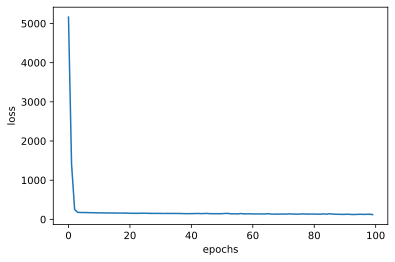

In [33]:
pd.DataFrame(history_1.history)['mae'].plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [35]:
labels_pred = model_1.predict(windows_test)

In [39]:
errors(labels_test, labels_pred)

{'MAE': 727.253,
 'MSE': 1690461.9,
 'RMSE': 1300.1776,
 'MAPE': 2.7123456,
 'MASE': 1.055117968042225}

In [58]:
np.squeeze(labels_test[:10]), np.squeeze(labels_pred[:10])

(array([6697.94831993, 6718.08487191, 6682.78062208, 6229.49331991,
        5879.81683565, 6483.6170416 , 6446.44266715, 6537.68699039,
        6796.92519575, 6772.00730095]),
 array([6516.2344, 6861.8257, 6798.6445, 6634.7925, 6297.7637, 5983.548 ,
        6317.909 , 6253.335 , 6733.6646, 6702.023 ], dtype=float32))

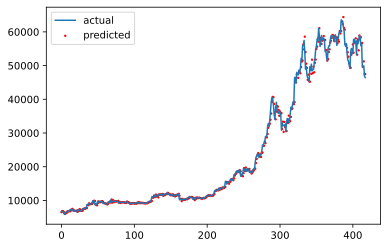

In [57]:
plt.scatter(range(len(labels_pred)),labels_pred,color='r', s=2, label='predicted')
plt.plot(labels_test, label='actual')
plt.legend();